# Problem
**Mục tiêu: Sử dụng các yếu tố sức khỏe để dự đoán một người có mắc bệnh tim hay không**

**Metric: AUC, Precision với Recall = 90 %**

Biến mục tiêu:

Có hai hướng đi:
1. Tình trạng bệnh tim với `0` là không mắc bệnh, `1` là mắc bệnh
2. Khả năng một người mắc bệnh tim (số thực mang giá trị `[0;1]`)
- **Important**: dataset của chúng ta không có sẵn biến mục tiêu dạng này, biến gần nhất là tình trạng bệnh tim nhận giá trị `0` hoặc `1`
- Đầu ra của mô hình phải phù hợp với các tính toán được y học chấp nhận

Thông qua phân tích sơ bộ, tỷ lệ mắc bệnh chung vào khoảng `8.6%`, để đầu ra thực sự có ích, thì với recall `90%` tôi mong muốn có thể có Precision tối thiểu `18%`, và với recall `95%`, precision `14%`.

Các biến dự đoán: vì đây là một vấn đề cần phân tích kỹ hơn, nên tôi sẽ thực hiện file `preprocessing.ipynb` trước khi đưa ra những nhận định về các biến dự đoán.

Tuy chúng ta không thể tự mình tìm kiếm thêm các thông tin về yếu tố sức khỏe, nhưng việc xem xét thêm các yếu tố nằm ngoài bộ dataset được chứng minh bằng các nghiên cứu y học có thể giúp ích cho việc cải tiến mô hình sau này. Vì thế, hãy xem qua một số nguồn:
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7210118/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7871691/



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data

In [2]:
df_origin = pd.read_csv('data/relevant_features.csv', index_col=0)
print(df_origin.shape)
df_origin.head()

(319795, 17)


,AgeCategory,Race,GenHealth,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,Diabetic,PhysicalActivity,KidneyDisease,SkinCancer,BMI,PhysicalHealth,MentalHealth,SleepTime
0,7,5,3,0,1,0,0,0,0,3,1,0,1,16.60,3.0,30.0,5.0
1,12,5,3,0,0,0,1,0,0,0,1,0,0,20.34,0.0,0.0,7.0
2,9,5,1,0,1,0,0,0,1,3,1,0,0,26.58,20.0,30.0,8.0
3,11,5,2,0,0,0,0,0,0,0,0,0,1,24.21,0.0,0.0,6.0
4,4,5,3,0,0,0,0,1,0,0,1,0,0,23.71,28.0,0.0,8.0


# Split train test sets

In [3]:
X = df_origin.drop('HeartDisease', axis=1)
y = df_origin['HeartDisease']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
print('Train set:\n',y_train.value_counts()/y_train.size, sep='')
print('Size of train set:', y_train.size)
print('Test set:\n',y_test.value_counts()/y_test.size, sep='')
print('Size of test set:', y_test.size)

Train set:
0    0.914753
1    0.085247
Name: HeartDisease, dtype: float64
Size of train set: 223856
Test set:
0    0.913591
1    0.086409
Name: HeartDisease, dtype: float64
Size of test set: 95939


# Data preprocessing and transforming

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Build, evaluate models, error analysis

## Import some important modules

In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, plot_roc_curve, RocCurveDisplay

import matplotlib.pyplot as plt

## Define evaluate function

Ở đây tôi sẽ tạo ra một function thực hiện việc in ra AUC, precisions, recalls, f1 scores (sklearn's classification report) ứng với recall 90% và 95%. Ngoài ra, function sẽ hiển thị roc curve và hình ảnh trực quan xác suất bị bệnh tính toán của mô hình cho từng phần tử

In [9]:
import matplotlib.colors as mpc
import matplotlib.patches as mpatches

def find_thres(tpr: np.ndarray, fpr: np.ndarray, thres: np.ndarray, recall = 0.9):
    idx = tpr.searchsorted(recall)
    return idx, tpr[idx], fpr[idx], thres[idx]


def evaluate(model, X, y, recalls = [0.9, 0.95], name = None):
    """
    return auc_score, target_thres, precisions
    """
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1,2,1)

    # predict probability
    prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, prob)
    prob_df = pd.DataFrame({'prob': prob, 'class': y})

    # auc
    auc_score = roc_auc_score(y, prob)
    print('AUC score =', auc_score)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    roc_plot.plot(ax=ax)
    if name:
        plt.title(name)
    target_thres = {}
    precisions = {}

    # precision for each recall scores
    try:
        for recall in recalls:
            _, _, _, thres = find_thres(tpr, fpr, thresholds, recall)
            target_thres[recall] = thres
            print('Recall =', recall)
            # print(classification_report(y, prob > thres))
            conf_matrix = confusion_matrix(y, prob > thres)
            precisions[recall] = conf_matrix[-1,-1]/np.sum(conf_matrix[:,-1])
            print('Precision =',precisions[recall])
    except TypeError as e:
        print(e)
    
    # Visualize
    prob_df.sort_values('prob', inplace=True, ignore_index=True)
    plt.subplot(1,2,2)
    sc = plt.scatter(x=prob_df.index, y=prob_df['prob'].values, c=prob_df['class'].values)
    hd_color = mpc.to_hex(sc.to_rgba(1))
    no_hd_color = mpc.to_hex(sc.to_rgba(0))
    hd_patch = mpatches.Patch(color=hd_color, label='Heart disease')
    no_hd_patch = mpatches.Patch(color=no_hd_color, label='Without heart disease')
    plt.ylabel('Probability')
    plt.legend(handles = [hd_patch, no_hd_patch])
    return auc_score, target_thres, precisions

## Metrics

In [10]:
auc_scores = {}
precisions = {}

## Models

In [11]:
models = {}

### Logistic Regression

In [13]:
model = LogisticRegression(class_weight='balanced', C=0.5, max_iter=300)
model.fit(X_train, y_train)
models['LR'] = model

AUC score = 0.841913380546931
Recall = 0.9
Precision = 0.17353785214825593
Recall = 0.95
Precision = 0.142681736611781


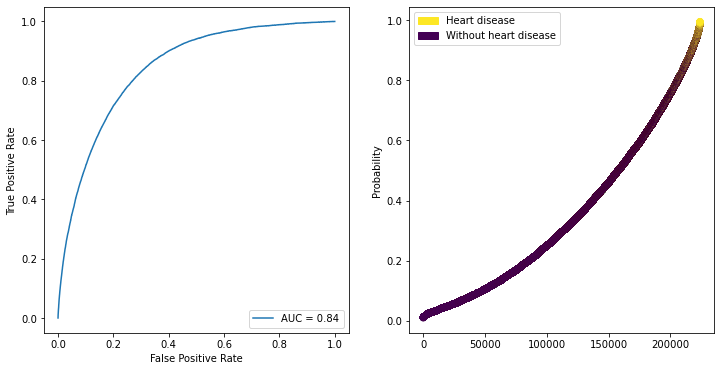

In [15]:
auc_score, target_thres, precision = evaluate(models['LR'], X_train, y_train)

AUC score = 0.8365712064519434
Recall = 0.9
Precision = 0.1704636336631401
Recall = 0.95
Precision = 0.14176162445320517


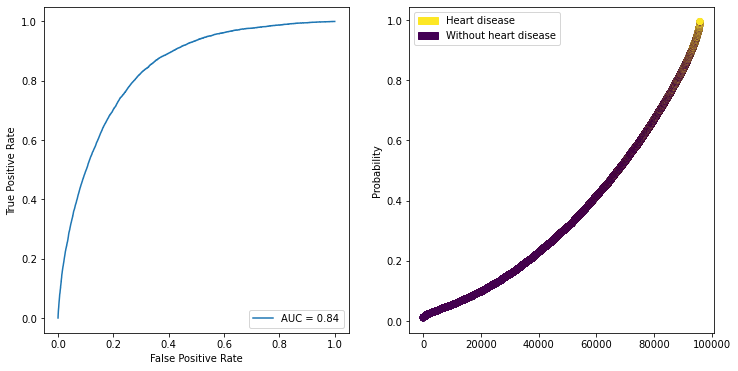

In [16]:
auc_score, target_thres, precision = evaluate(models['LR'], X_test, y_test)
auc_scores['LR'] = auc_score
precisions['LR'] = precision

### SVM

In [34]:
# model = SVC(class_weight='balanced', probability=True)
# model.fit(X_test, y_test)

In [35]:
# auc_score, target_thres, precision = evaluate(model, X_train, y_train)

In [36]:
# auc_score, target_thres, precision = evaluate(model, X_test, y_test)
# models['svm'] = model
# auc_scores['svm'] = auc_score
# precisions['svm'] = precision

### SGD

In [17]:
model = SGDClassifier(loss='log')
model.fit(X_train, y_train)
models['SGD'] = model

AUC score = 0.8232063897225502
Recall = 0.9
Precision = 0.15476801917479885
Recall = 0.95
Precision = 0.1285974731674789


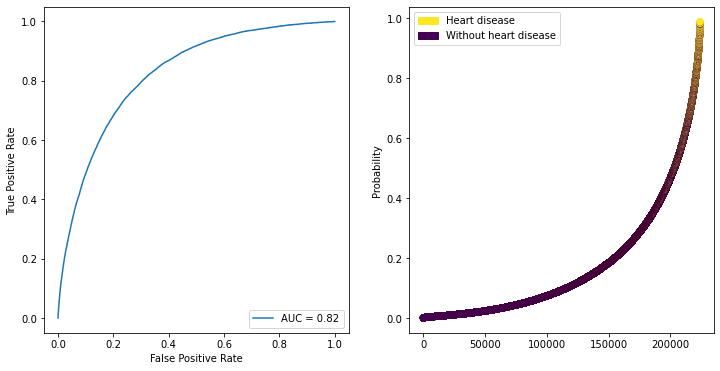

In [18]:
auc_score, target_thres, precision = evaluate(models['SGD'], X_train, y_train)

AUC score = 0.8172480882150005
Recall = 0.9
Precision = 0.15129390768232334
Recall = 0.95
Precision = 0.1257685858021241


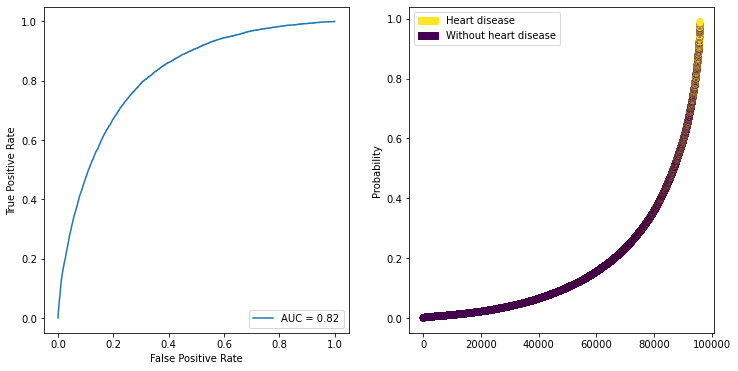

In [19]:
auc_score, target_thres, precision = evaluate(models['SGD'], X_test, y_test)
auc_scores['SGD'] = auc_score
precisions['SGD'] = precision

### Tree

In [20]:
model = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=600)
model.fit(X_train, y_train)
models['tree'] = model

AUC score = 0.83951759534146
Recall = 0.9
Precision = 0.17291240515512743
Recall = 0.95
Precision = 0.14545191867791413


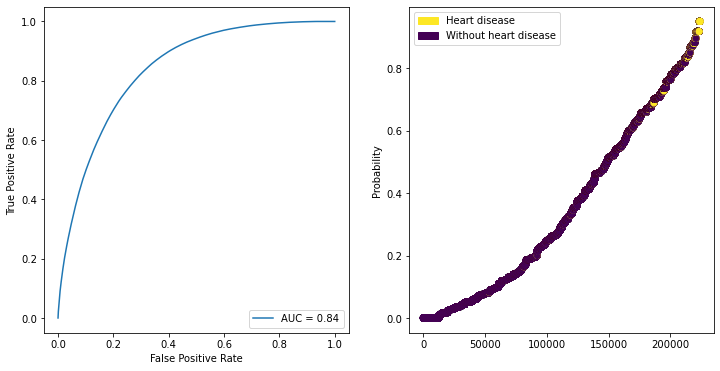

In [21]:
auc_score, target_thres, precision = evaluate(models['tree'], X_train, y_train)

AUC score = 0.8264287140969296
Recall = 0.9
Precision = 0.16804072622426455
Recall = 0.95
Precision = 0.13851678431234488


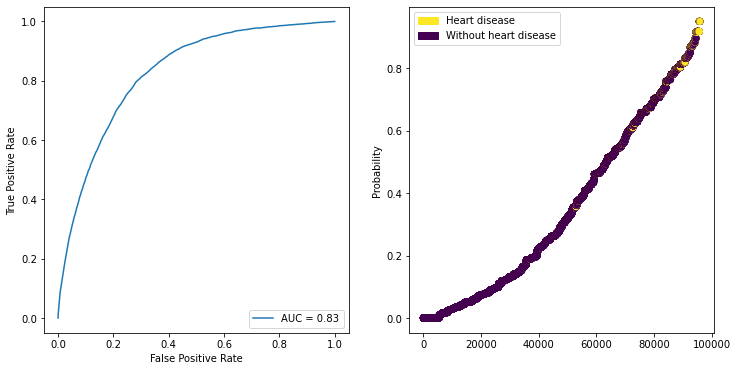

In [22]:
auc_score, target_thres, precision = evaluate(models['tree'], X_test, y_test)
auc_scores['tree'] = auc_score
precisions['tree'] = precision

### Random forest

In [23]:
model = RandomForestClassifier(min_samples_leaf=200)
model.fit(X_train, y_train)
models['forest'] = model

AUC score = 0.8499647233042211
Recall = 0.9
Precision = 0.17786016839445312
Recall = 0.95
Precision = 0.14931347758403413


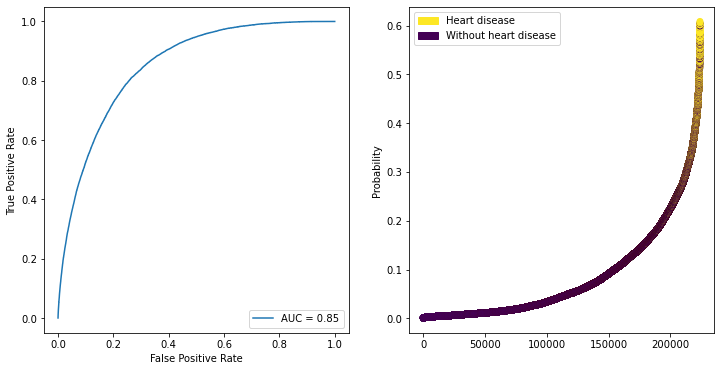

In [24]:
auc_score, target_thres, precision = evaluate(models['forest'], X_train, y_train)

AUC score = 0.8379841297578243
Recall = 0.9
Precision = 0.1743153565753809
Recall = 0.95
Precision = 0.14096734927681512


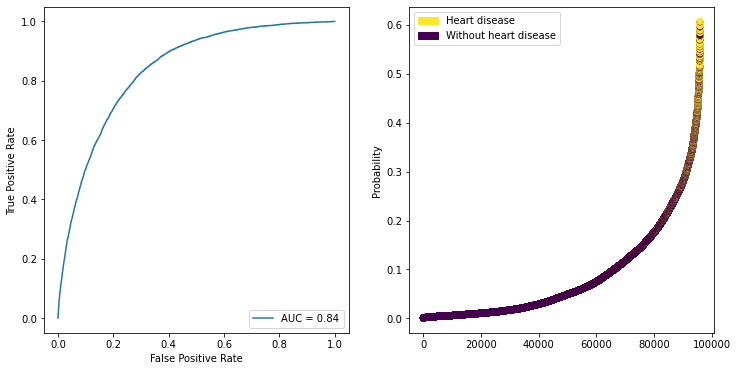

In [25]:
auc_score, target_thres, precision = evaluate(models['forest'], X_test, y_test)
auc_scores['forest'] = auc_score
precisions['forest'] = precision

### Naive Bayes

In [26]:
model = GaussianNB()
model.fit(X_train, y_train)
models['NB'] = model

AUC score = 0.8088647269726097
Recall = 0.9
Precision = 0.15678577297376253
Recall = 0.95
Precision = 0.13202723862932886


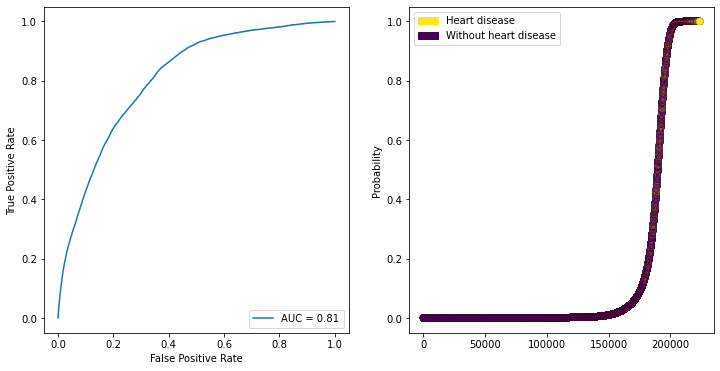

In [27]:
auc_score, target_thres, precision = evaluate(models['NB'], X_train, y_train)

AUC score = 0.804077457843594
Recall = 0.9
Precision = 0.156808340690293
Recall = 0.95
Precision = 0.1296851327317041


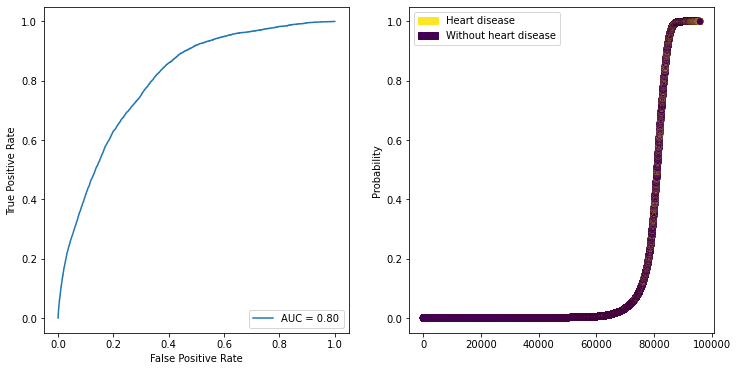

In [28]:
auc_score, target_thres, precision = evaluate(models['NB'], X_test, y_test)
auc_scores['NB'] = auc_score
precisions['NB'] = precision

### AdaBoost

In [29]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
models['Ada'] = model

AUC score = 0.8414739627563547
Recall = 0.9
Precision = 0.17295778053129438
Recall = 0.95
Precision = 0.14362570319309087


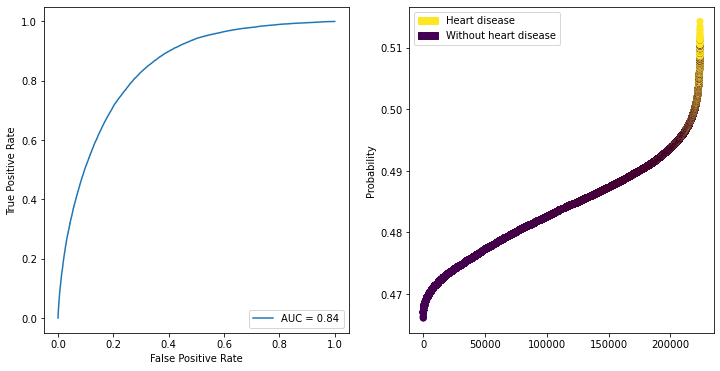

In [30]:
auc_score, target_thres, precision = evaluate(models['Ada'], X_train, y_train)

AUC score = 0.8361862221836933
Recall = 0.9
Precision = 0.17166394366845386
Recall = 0.95
Precision = 0.1405396723417925


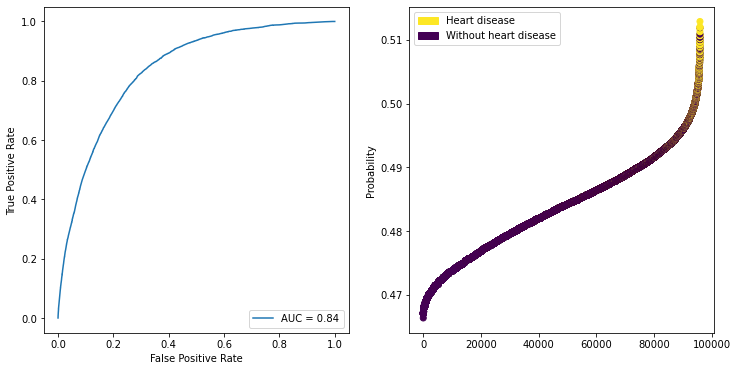

In [31]:
auc_score, target_thres, precision = evaluate(models['Ada'], X_test, y_test)
auc_scores['Ada'] = auc_score
precisions['Ada'] = precision

### Gradient Boosting

In [32]:
model = GradientBoostingClassifier(max_depth=5)
model.fit(X_train, y_train)
models['GDB'] = model

AUC score = 0.8525556453641845
Recall = 0.9
Precision = 0.17817940364783266
Recall = 0.95
Precision = 0.14854998238181474


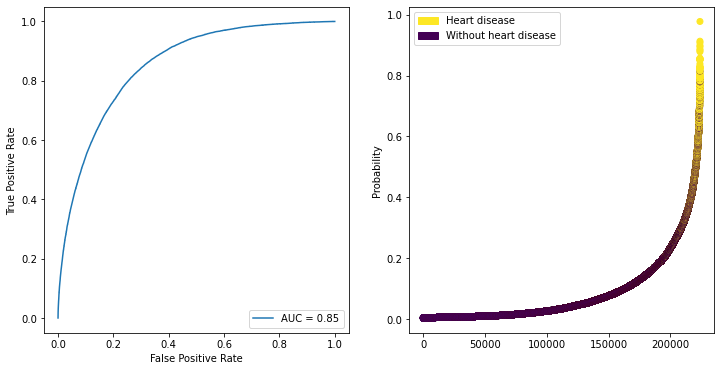

In [33]:
auc_score, target_thres, precision = evaluate(models['GDB'], X_train, y_train)

AUC score = 0.8405012984884978
Recall = 0.9
Precision = 0.17605135224430074
Recall = 0.95
Precision = 0.14365457231981613


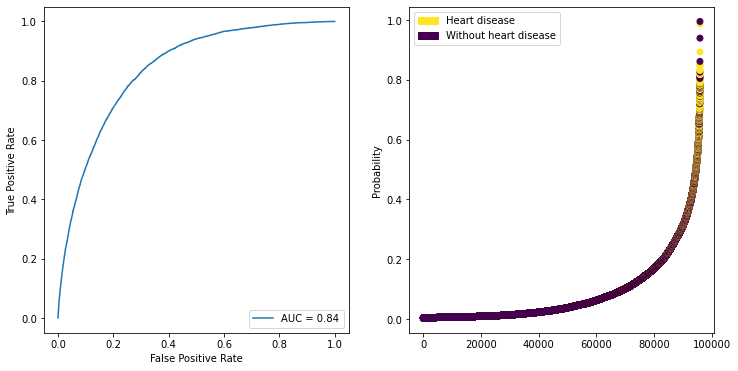

In [34]:
auc_score, target_thres, precision = evaluate(models['GDB'], X_test, y_test)
auc_scores['GDB'] = auc_score
precisions['GDB'] = precision

### Ensemble

In [35]:
models

{'LR': LogisticRegression(C=0.5, class_weight='balanced', max_iter=300),
 'SGD': SGDClassifier(loss='log'),
 'tree': DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=600),
 'forest': RandomForestClassifier(min_samples_leaf=200),
 'NB': GaussianNB(),
 'Ada': AdaBoostClassifier(),
 'GDB': GradientBoostingClassifier(max_depth=5)}

In [36]:
estimators = {}
for model_name in models:
    if precisions[model_name][0.95] > 0.135:
        estimators[model_name] = models[model_name]

In [37]:
estimators = {}
for model_name in models:
    if precisions[model_name][0.95] > 0.135:
        estimators[model_name] = models[model_name]
model = VotingClassifier(estimators.items(),voting='soft')
model.fit(X_train, y_train)
models['ens'] = model

AUC score = 0.8490461742934774
Recall = 0.9
Precision = 0.1778841174155325
Recall = 0.95
Precision = 0.14777136522221135


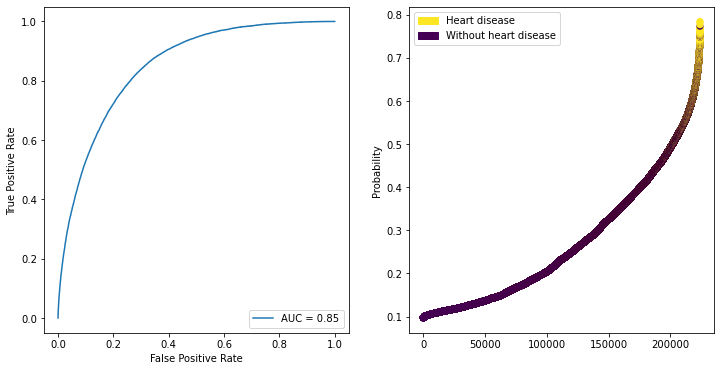

In [38]:
auc_score, target_thres, precision = evaluate(models['ens'], X_train, y_train)

AUC score = 0.8380746232563949
Recall = 0.9
Precision = 0.17240980840786707
Recall = 0.95
Precision = 0.14410144741898295


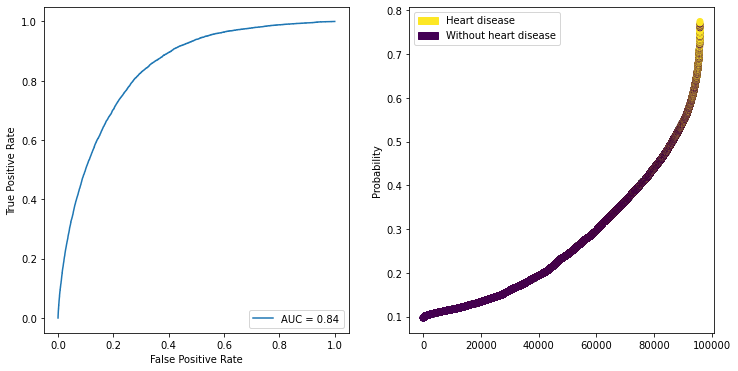

In [39]:
auc_score, target_thres, precision = evaluate(models['ens'], X_test, y_test)
auc_scores['ens'] = auc_score
precisions['ens'] = precision

### My ensemble model

In [40]:
class my_ensemble():
    def __init__(self,estimators):
        self.estimators = estimators
    
    def predict_proba(self, X):
        pred_prob = np.zeros((X.shape[0], 2))
        for estimator_name, estimator in self.estimators.items():
            prob = estimator.predict_proba(X)
            pred_prob = pred_prob + prob
        pred_prob = pred_prob/len(self.estimators)
        return pred_prob
    

In [41]:
model = my_ensemble(estimators)
models['my_ens'] = model

AUC score = 0.8490494125294051
Recall = 0.9
Precision = 0.17778836000745357
Recall = 0.95
Precision = 0.1479232966136271


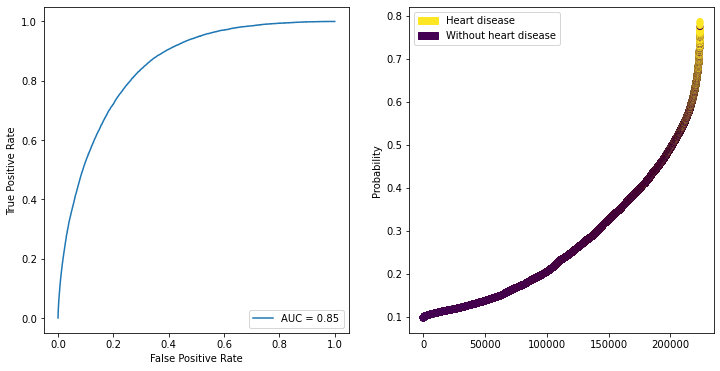

In [42]:
auc_score, target_thres, precision = evaluate(models['my_ens'], X_train, y_train)

AUC score = 0.8380716711921788
Recall = 0.9
Precision = 0.17247358564723833
Recall = 0.95
Precision = 0.14428362037376327


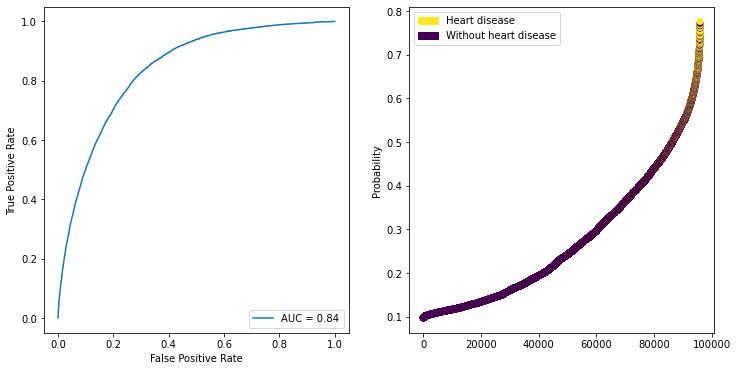

In [43]:
auc_score, target_thres, precision = evaluate(models['my_ens'], X_test, y_test)
auc_scores['my_ens'] = auc_score
precisions['my_ens'] = precision

In [44]:
pd.DataFrame(precisions).transpose()

,0.90,0.95
LR,0.170464,0.141762
SGD,0.151294,0.125769
tree,0.168041,0.138517
forest,0.174315,0.140967
NB,0.156808,0.129685
Ada,0.171664,0.140540
GDB,0.176051,0.143655
ens,0.172410,0.144101
my_ens,0.172474,0.144284


Với bộ dữ liệu hoàn chỉnh, có vẻ dễ dàng đạt được mục tiêu đã đề ra. Chúng ta có thể làm thêm một số điều để kết quả tốt hơn như thêm vào việc đánh dấu outlier, scale dữ liệu, tuy nhiên, vì đây không phải là bộ dữ liệu sử dụng cuối cùng nên tôi sẽ dừng tại đây.

# Selective features

In [45]:
df_selective = pd.read_csv('data/selective_features.csv', index_col=0)
print(df_selective.shape)
df_selective.head()

(319795, 8)


,BMI,Smoking,AlcoholDrinking,Sex,AgeCategory,Race,Diabetic,HeartDisease
0,16.60,1,0,0,7,5,3,0
1,20.34,0,0,0,12,5,0,0
2,26.58,1,0,1,9,5,3,0
3,24.21,0,0,0,11,5,0,0
4,23.71,0,0,0,4,5,0,0


In [46]:
X = df_selective.drop('HeartDisease', axis=1)
y = df_selective['HeartDisease']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# Scale data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [49]:
model = VotingClassifier(estimators.items(), voting='soft')
model.fit(X_train,y_train)

VotingClassifier(estimators=dict_items([('LR', LogisticRegression(C=0.5, class_weight='balanced', max_iter=300)), ('tree', DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=600)), ('forest', RandomForestClassifier(min_samples_leaf=200)), ('Ada', AdaBoostClassifier()), ('GDB', GradientBoostingClassifier(max_depth=5))]),
                 voting='soft')

AUC score = 0.7938533274945311
Recall = 0.9
Precision = 0.1470559246190542
Recall = 0.95
Precision = 0.12763578015851149


(0.7938533274945311,
 {0.9: 0.25368661391387115, 0.95: 0.1985169066677192},
 {0.9: 0.1470559246190542, 0.95: 0.12763578015851149})

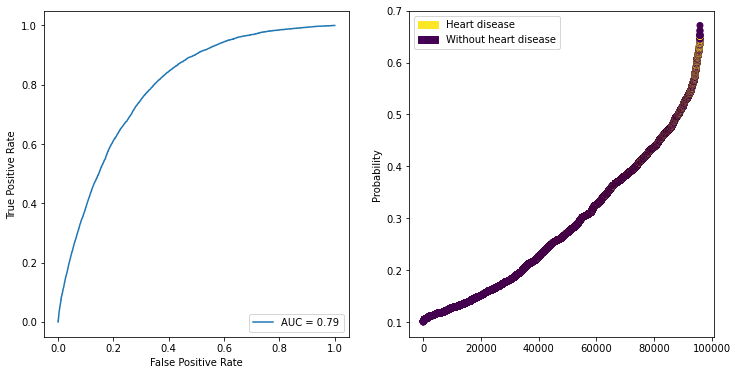

In [50]:
evaluate(model, X_test,y_test)

Với bộ dữ liệu chỉ sử dụng những dữ liệu phù hợp với thực tế. Các mô hình với các tham số trước đó có vẻ hoạt động chưa tốt. Tôi sẽ chọn một số mô hình có vẻ hiệu quả và tinh chỉnh các tham số

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [52]:
models = {}
auc_scores = {}
precisions = {}

In [53]:
# Define score function
score_fn = make_scorer(roc_auc_score, needs_proba=True)

## Logistic Regression

In [54]:
estimator = LogisticRegression()
param = {
         'class_weight':['balanced', None],
         'C': [i/5 for i in range(5)],
         'penalty': ['l2', 'elasticnet']
}
model = GridSearchCV(estimator, param_grid=param, scoring=score_fn)


In [ ]:
model.fit(X_train, y_train)

AUC score = 0.7913585015547744
Recall = 0.9
Precision = 0.14629172059457976
Recall = 0.95
Precision = 0.12550800860626346


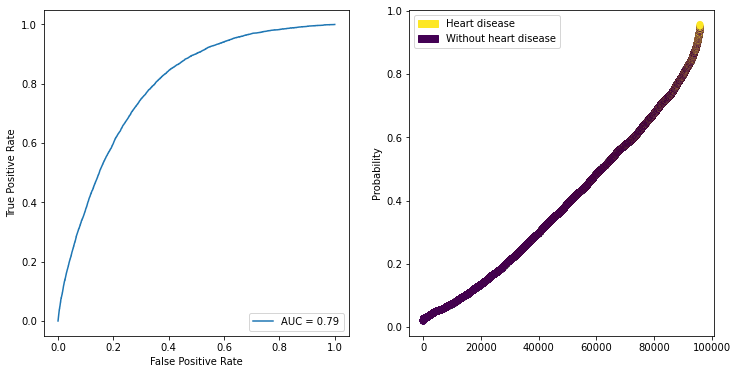

In [56]:
auc_score, target_thres, precision = evaluate(model.best_estimator_, X_test, y_test)

In [57]:
models['LR'] = model.best_estimator_
precisions['LR'] = precision
auc_scores = auc_score

In [ ]:
# Fit scaled data
model = GridSearchCV(estimator, param_grid=param, scoring=score_fn)
model.fit(X_train_sc, y_train)

AUC score = 0.7913648488369025
Recall = 0.9
Precision = 0.14633763584291262
Recall = 0.95
Precision = 0.12549000860502915


(0.7913648488369025,
 {0.9: 0.3429995906796161, 0.95: 0.235083023364188},
 {0.9: 0.14633763584291262, 0.95: 0.12549000860502915})

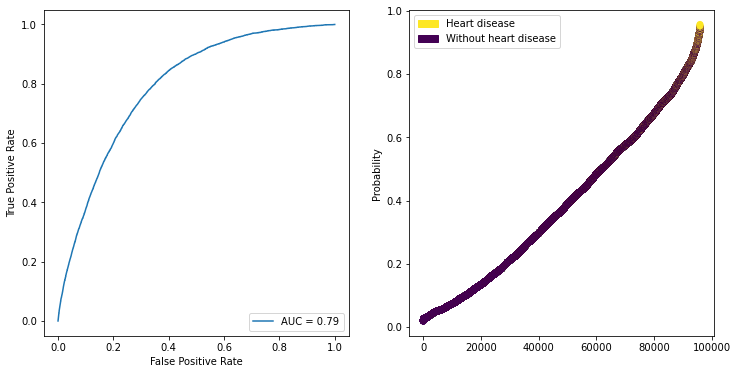

In [59]:
evaluate(model.best_estimator_, X_test_sc, y_test)

## Decision tree

In [60]:
estimator = DecisionTreeClassifier()
param = {
         'class_weight':['balanced', None],
         'criterion': ['gini', 'entropy'],
         'min_samples_leaf': [(i+1)*20 for i in range(5,10)]
}

In [62]:
param = {
         'class_weight':['balanced'],
         'criterion': ['gini'],
         'min_samples_leaf': [(i+1)*20 for i in range(8,15)]
}
model = GridSearchCV(estimator, param_grid=param, scoring=score_fn)
model.fit(X_train, y_train)
print('Best parameters:',model.best_params_)

Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_leaf': 280}


AUC score = 0.7858791730988752
Recall = 0.9
Precision = 0.14463883932035068
Recall = 0.95
Precision = 0.12239530649403196


(0.7858791730988752,
 {0.9: 0.3205030432630511, 0.95: 0.1902688087118921},
 {0.9: 0.14463883932035068, 0.95: 0.12239530649403196})

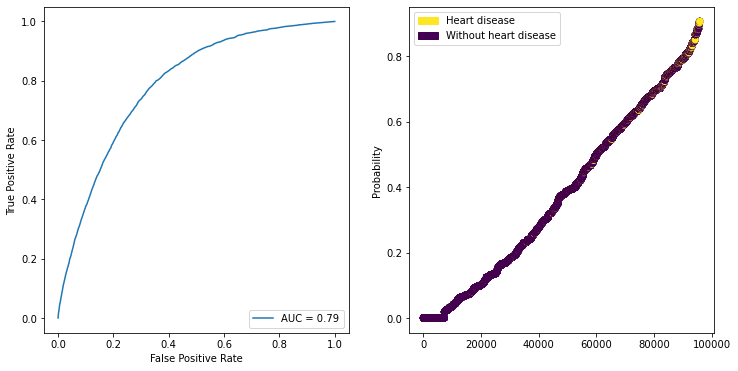

In [63]:
evaluate(model.best_estimator_, X_test, y_test)

## Random forest

In [64]:
estimator = RandomForestClassifier(class_weight='balanced')
param = {
         'min_samples_leaf': [(i+1)*20 for i in range(5,10)],
         'n_estimators': [(i+1)*10 for i in range(5,10)]
}

In [65]:
model = GridSearchCV(estimator, param_grid=param, scoring=score_fn)
model.fit(X_train, y_train)
print('Best parameters:',model.best_params_)

Best parameters: {'min_samples_leaf': 180, 'n_estimators': 100}


AUC score = 0.7934008806454839
Recall = 0.9
Precision = 0.14848726114649682
Recall = 0.95
Precision = 0.12746018386637317


(0.7934008806454839,
 {0.9: 0.3486046390243414, 0.95: 0.22437072291649834},
 {0.9: 0.14848726114649682, 0.95: 0.12746018386637317})

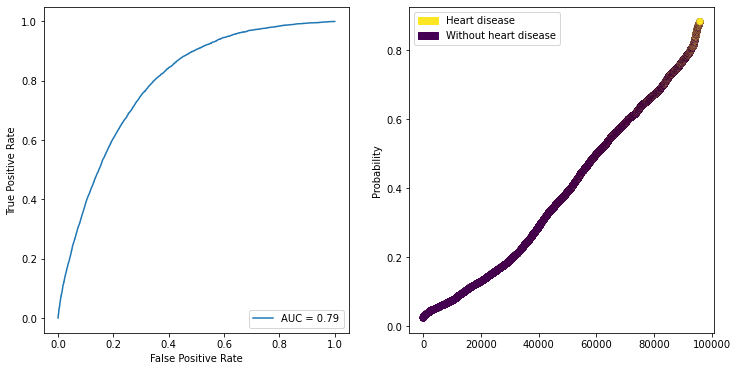

In [66]:
evaluate(model.best_estimator_, X_test, y_test)

## K nearest neighbors

In [47]:
model = KNeighborsClassifier(n_neighbors=200, p=1)
model.fit(X_train_sc, y_train)


KNeighborsClassifier(n_neighbors=200, p=1)

AUC score = 0.784979380485171
Recall = 0.9
Precision = 0.14800732291226587
Recall = 0.95
Precision = 0.12769801898879726


(0.784979380485171,
 {0.9: 0.04, 0.95: 0.02},
 {0.9: 0.14800732291226587, 0.95: 0.12769801898879726})

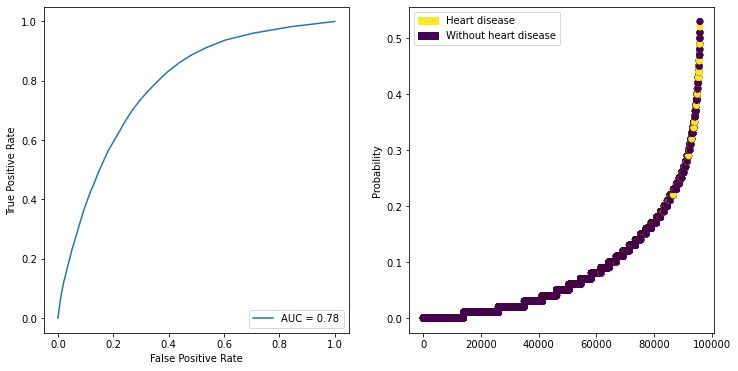

In [46]:
evaluate(model, X_test_sc, y_test)

# Summary

Nhìn chung với dữ liệu dầy đủ, mô hình hoạt động tốt và đạt được mục tiêu đề ra. Tuy nhiên, với các dữ liệu thực sự có ích, yêu cầu là chưa đạt được. Điều này cũng dễ hiểu, vì khó có thể dự báo được nguy cơ tim mạch mà không nhìn được rõ ràng về lâm sàng.

Để mô hình tuy không đạt mức yêu cầu nhưng vẫn có thể ứng dụng, ta có thể thêm yếu tố "cải thiện". Ví dụ, thay vì dự báo kết quả nguy cơ tim mạch thì ta sẽ báo cho người dùng biết, nếu họ có thể cải thiện các yếu tố xấu, thì nguy cơ mắc bệnh tim mạch giảm như thế nào. Từ đó vẫn có thể thuyết phục người dùng thực hiện lối sống lành mạnh.